<a href="https://colab.research.google.com/github/pippahtlin/Extreme-Precipitation/blob/main/univariate_daily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import MinMaxScaler

In [21]:
df = pd.read_csv("https://raw.githubusercontent.com/pippahtlin/Extreme-Precipitation/main/data/precipitation_soi",index_col = "date")
df.index = pd.to_datetime(df.index)
df

,year,month,day,daily rain,binary rain,soi
date,,,,,,
1899-10-11,1899,10,11,3.048000,0,-1
1899-10-12,1899,10,12,2.032000,0,-1
1899-10-13,1899,10,13,33.020000,1,-1
1899-10-14,1899,10,14,0.508000,0,-1
1899-10-15,1899,10,15,0.000000,0,-1
...,...,...,...,...,...,...
2022-12-27,2022,12,27,0.000000,0,1
2022-12-28,2022,12,28,22.859999,0,1
2022-12-29,2022,12,29,0.000000,0,1


<br>

## 2. Split Data
Training set: 60% | Validation set: 20% | Testing set: 20%

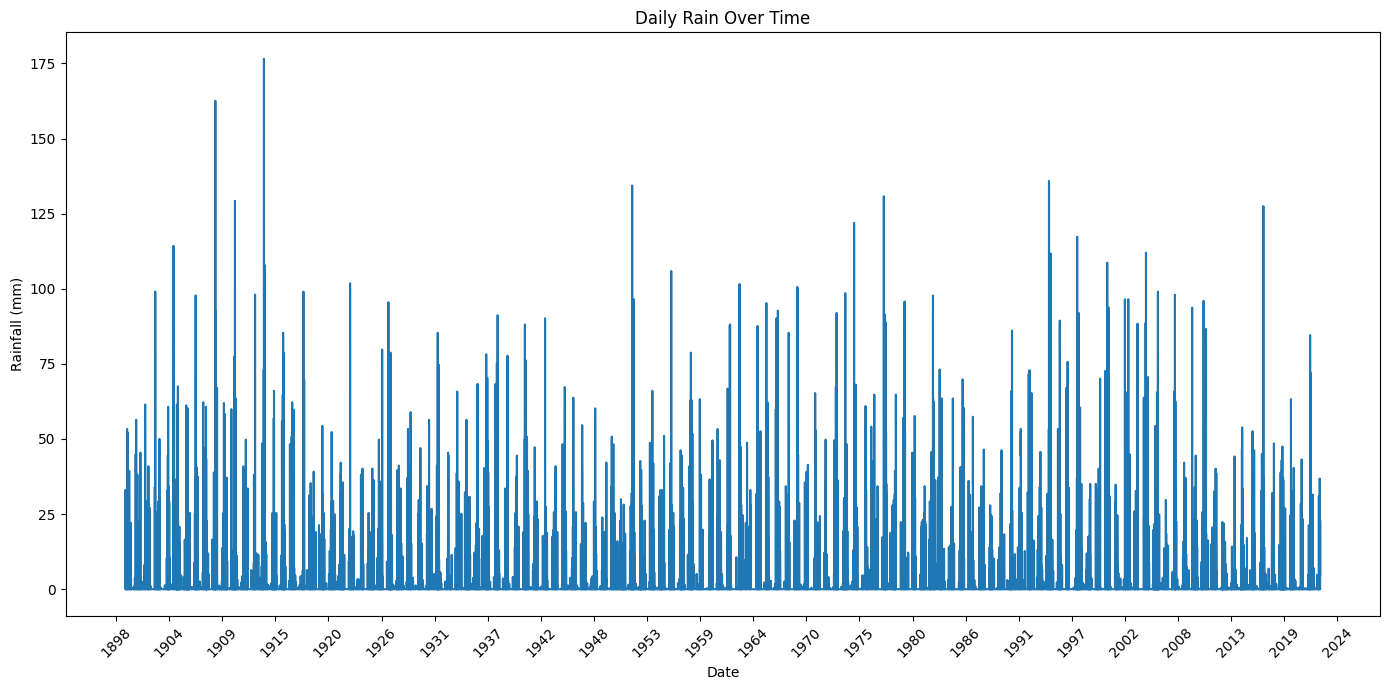

In [22]:
plt.figure(figsize=(14, 7))
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=30))

plt.plot(df.index,df['daily rain'],label = 'Daily Rain')
plt.title('Daily Rain Over Time')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.tight_layout()
plt.show()

In [23]:
# Calculate indices for splitting
total_rows = len(df)
train_end = int(total_rows * 0.6)
validation_end = train_end + int(total_rows * 0.2)

# Using iloc for integer-location based indexing
train = df[["daily rain"]].iloc[:train_end]
validation = df[["daily rain"]].iloc[train_end:validation_end]
test = df[["daily rain"]].iloc[validation_end:]

<br>

## 3. Standardize Data and create series
MinMaxScaler

In [24]:
"""
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(train)
validation_scaled = sc.transform(validation)
test_scaled = sc.transform(test)

print(type(train_scaled))
train_scaled
"""

'\nsc = MinMaxScaler(feature_range=(0,1))\ntrain_scaled = sc.fit_transform(train)\nvalidation_scaled = sc.transform(validation)\ntest_scaled = sc.transform(test)\n\nprint(type(train_scaled))\ntrain_scaled\n'

In [25]:
sc = MinMaxScaler(feature_range=(0,80))
train_scaled = sc.fit_transform(train)
validation_scaled = sc.transform(validation)
test_scaled = sc.transform(test)

print(type(train_scaled))
train_scaled

<class 'numpy.ndarray'>


array([[ 1.38129496],
       [ 0.92086331],
       [14.96402878],
       ...,
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

In [26]:
T = 90 # Consider seasonality

# Train
X_train = []
y_train = []
for i in range(T,train_scaled.shape[0]):
    X_train.append(train_scaled[i-T:i])
    y_train.append(train_scaled[i])
X_train, y_train = np.array(X_train), np.array(y_train)

# Validation
X_validation = []
y_validation = []

for i in range(T, validation_scaled.shape[0]):
    X_validation.append(validation_scaled[i-T:i])
    y_validation.append(validation_scaled[i])
X_validation, y_validation = np.array(X_validation), np.array(y_validation)

# M, T, N
print(X_train.shape, y_train.shape)
print(X_validation.shape, y_validation.shape)

(26914, 90, 1) (26914, 1)
(8911, 90, 1) (8911, 1)


<br>

## 4. Build LSTM Model

In [27]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from keras import metrics
from time import time

In [28]:
model = Sequential()

# 1st Layer
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
#model.add(Dropout(0.2))

# 2nd Layer
model.add(LSTM(units = 50))
#model.add(Dropout(0.2))

# 3rd Layer
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=[metrics.MeanSquaredError(),metrics.AUC()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 90, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
model.fit(X_train, y_train, epochs = 30, batch_size = 32)
model.save("model_upper80-epoch30.h5")

Epoch 1/30
842/842 [==============================] - 83s 93ms/step - loss: 8.6002 - mean_squared_error: 8.6002 - auc: 0.7428
Epoch 2/30
842/842 [==============================] - 78s 93ms/step - loss: 8.4560 - mean_squared_error: 8.4560 - auc: 0.7590
Epoch 3/30
842/842 [==============================] - 77s 92ms/step - loss: 8.4305 - mean_squared_error: 8.4305 - auc: 0.7631
Epoch 4/30
842/842 [==============================] - 81s 97ms/step - loss: 8.4166 - mean_squared_error: 8.4166 - auc: 0.7649
Epoch 5/30
842/842 [==============================] - 82s 98ms/step - loss: 8.3997 - mean_squared_error: 8.3997 - auc: 0.7651
Epoch 6/30
842/842 [==============================] - 78s 92ms/step - loss: 8.3773 - mean_squared_error: 8.3773 - auc: 0.7674
Epoch 7/30
842/842 [==============================] - 69s 82ms/step - loss: 8.3733 - mean_squared_error: 8.3733 - auc: 0.7654
Epoch 8/30
842/842 [==============================] - 68s 80ms/step - loss: 8.3628 - mean_squared_error: 8.3628 - auc:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
"""
model.fit(X_train, y_train, epochs = 50, batch_size = 32)
model.save("model_upper80.h5")
"""

'\nmodel.fit(X_train, y_train, epochs = 50, batch_size = 32)\nmodel.save("model_upper80.h5")\n'

<br>

## 5. Model Evaluation

In [31]:
validation_predictions = model.predict(X_validation)
validation_predictions = sc.inverse_transform(validation_predictions)
validation_actual = sc.inverse_transform(y_validation.reshape(-1,1))

279/279 [==============================] - 7s 23ms/step


In [32]:
validation_compare = pd.DataFrame({'Actual': validation_actual.flatten(), 'Predicted': validation_predictions.flatten()})
validation_compare.head(20)

,Actual,Predicted
0,0.000,2.285313
1,0.000,2.080319
2,0.000,1.894785
3,0.000,1.732023
4,0.000,1.592641
5,0.000,1.477551
6,4.064,1.388835
7,0.000,3.014624
8,0.000,2.025310
9,0.000,1.896829


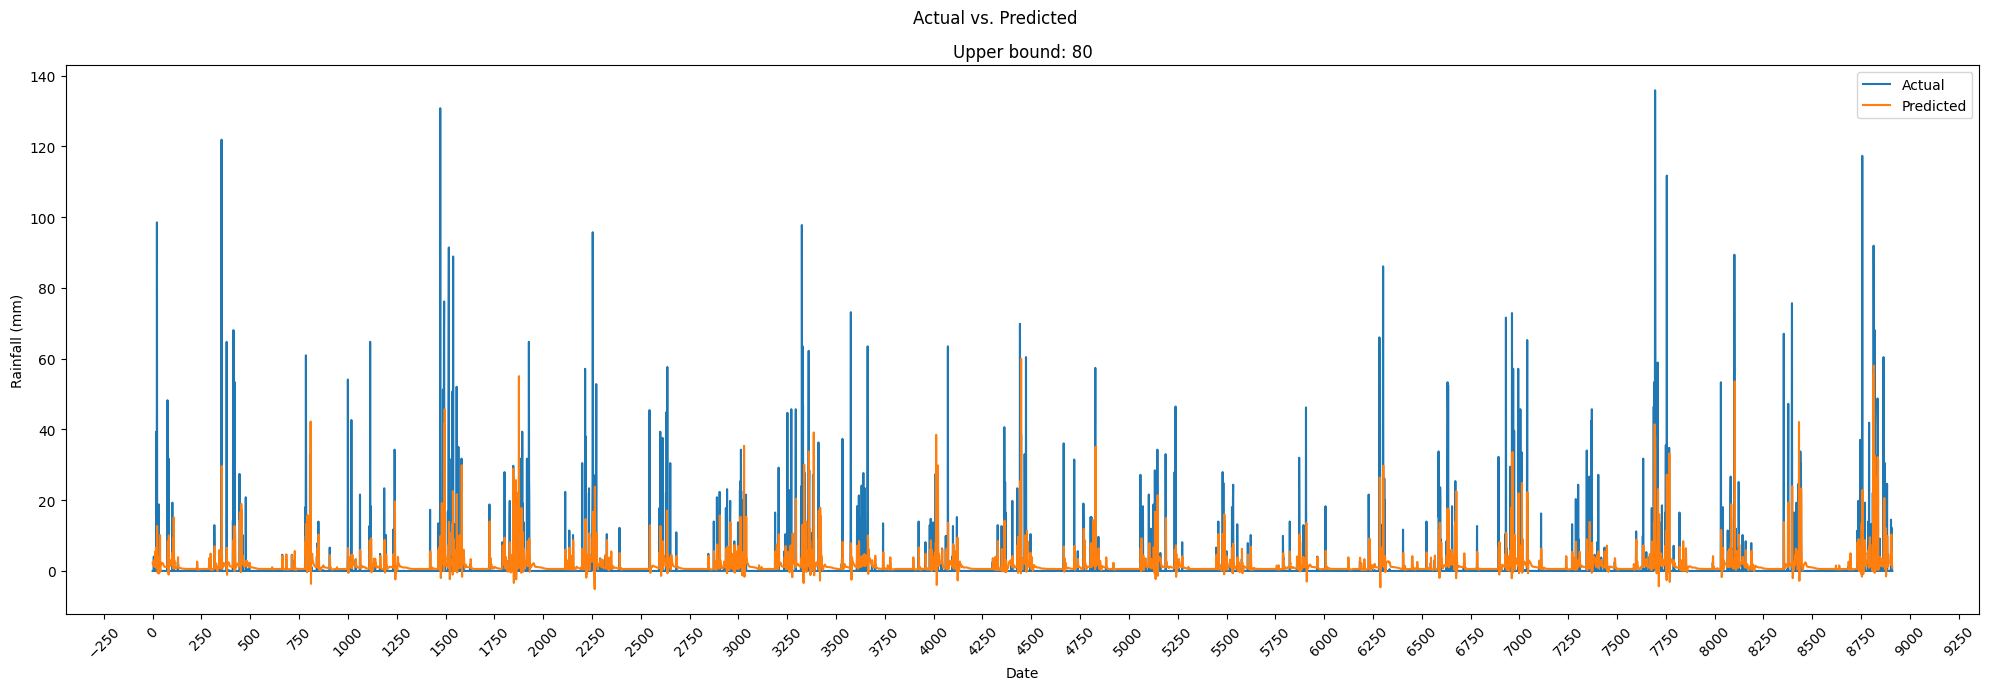

In [33]:
plt.figure(figsize=(20, 7))
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=40))

plt.plot(validation_compare['Actual'])
plt.plot(validation_compare['Predicted'])
plt.legend(['Actual', 'Predicted'])
plt.suptitle("Actual vs. Predicted")
plt.title("Upper bound: 80")
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.tight_layout()

plt.show()

In [34]:
"""
plt.figure(figsize=(20, 7))
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=40))

plt.plot(validation_compare['Actual'])
plt.plot(validation_compare['Predicted'])
plt.legend(['Actual', 'Predicted'])
plt.suptitle("Actual vs. Predicted")
plt.title("Upper bound: 80")
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.tight_layout()

plt.savefig('compare_upper80.png')


plt.show()
"""

'\nplt.figure(figsize=(20, 7))\nplt.xticks(rotation=45)\nplt.gca().xaxis.set_major_locator(MaxNLocator(nbins=40))\n\nplt.plot(validation_compare[\'Actual\'])\nplt.plot(validation_compare[\'Predicted\'])\nplt.legend([\'Actual\', \'Predicted\'])\nplt.suptitle("Actual vs. Predicted")\nplt.title("Upper bound: 80")\nplt.xlabel(\'Date\')\nplt.ylabel(\'Rainfall (mm)\')\nplt.tight_layout()\n\nplt.savefig(\'compare_upper80.png\')\n\n\nplt.show()\n'

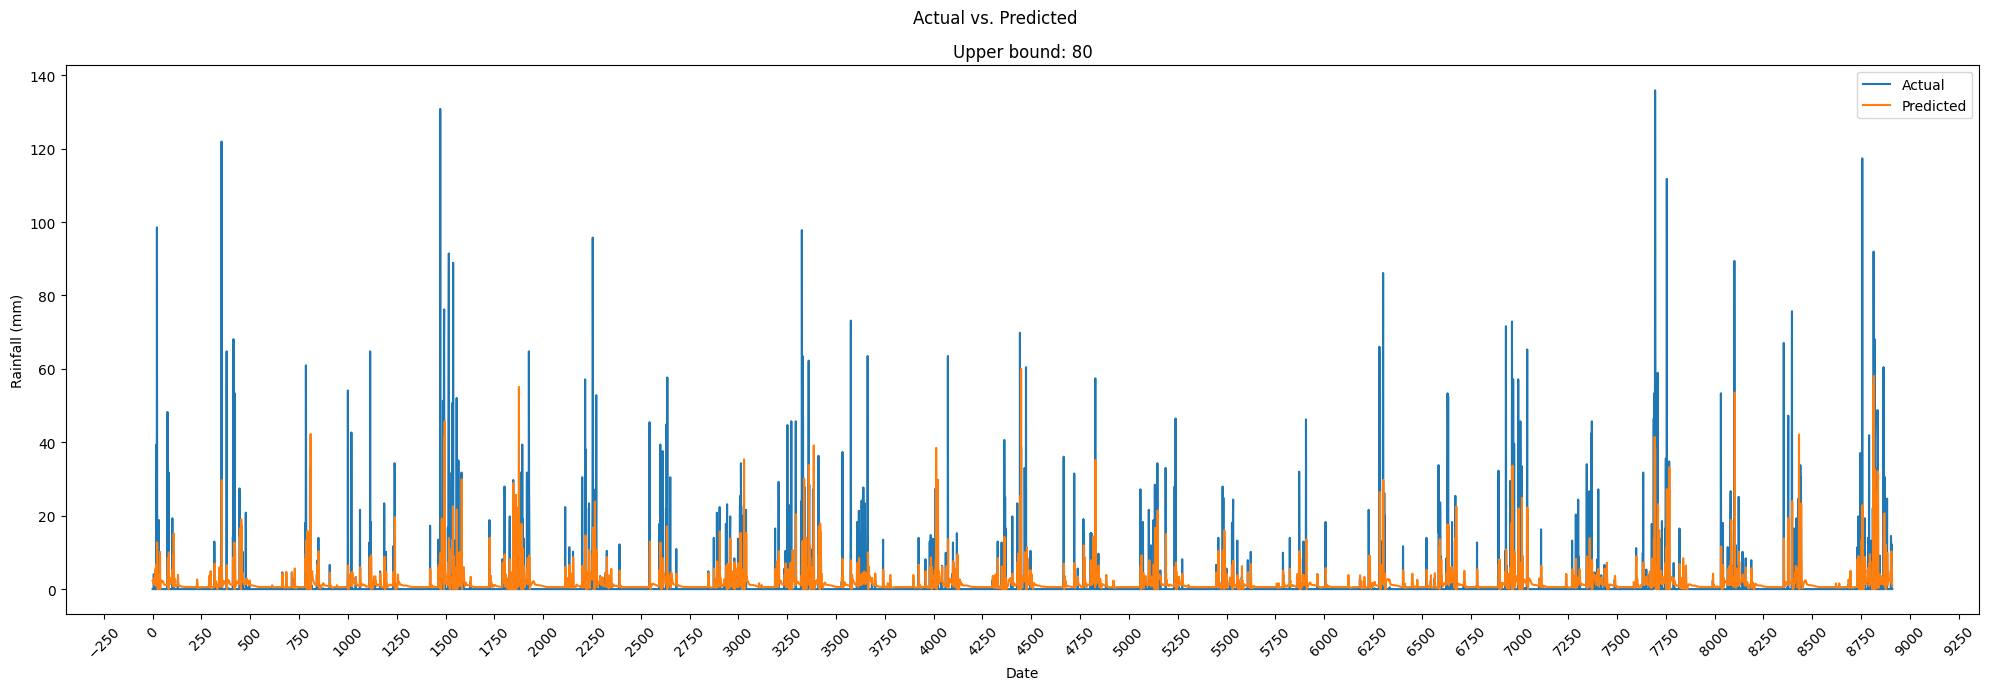

In [37]:
# For upper = 80

# Turn negative prediction to 0
validation_compare['Predicted'] = validation_compare['Predicted'].clip(lower=0)

plt.figure(figsize=(20, 7))
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=40))

plt.plot(validation_compare['Actual'])
plt.plot(validation_compare['Predicted'])
plt.legend(['Actual', 'Predicted'])
plt.suptitle("Actual vs. Predicted")
plt.title("Upper bound: 80")
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.tight_layout()

plt.savefig('compare_nor_upper80.png')


plt.show()


In [38]:
eval = model.evaluate(validation_compare['Actual'],validation_compare['Predicted'])
print(f"Loss: {eval[0]}")
print(f"MSE: {eval[1]}")
print(f"AUC: {eval[2]}")

279/279 [==============================] - 1s 3ms/step - loss: 13.6366 - mean_squared_error: 13.6366 - auc: 0.4433
Loss: 13.636602401733398
MSE: 13.636602401733398
AUC: 0.44327807426452637


### Result:
#### Upper bound = 1 + epoch = 50::
- Loss: 5.882976531982422,<br>MSE: 5.882976531982422,<br>AUC: 0.0

#### Upper bound = 80 + epoch = 50::
- Loss: 21.750621795654297,<br>MSE: 21.750621795654297,<br>AUC: 0.4865093529224396

#### Upper bound = 80 + epoch = 30:
- Loss: 13.636602401733398, <br>MSE: 13.636602401733398,<br>AUC: 0.44327807426452637
